In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


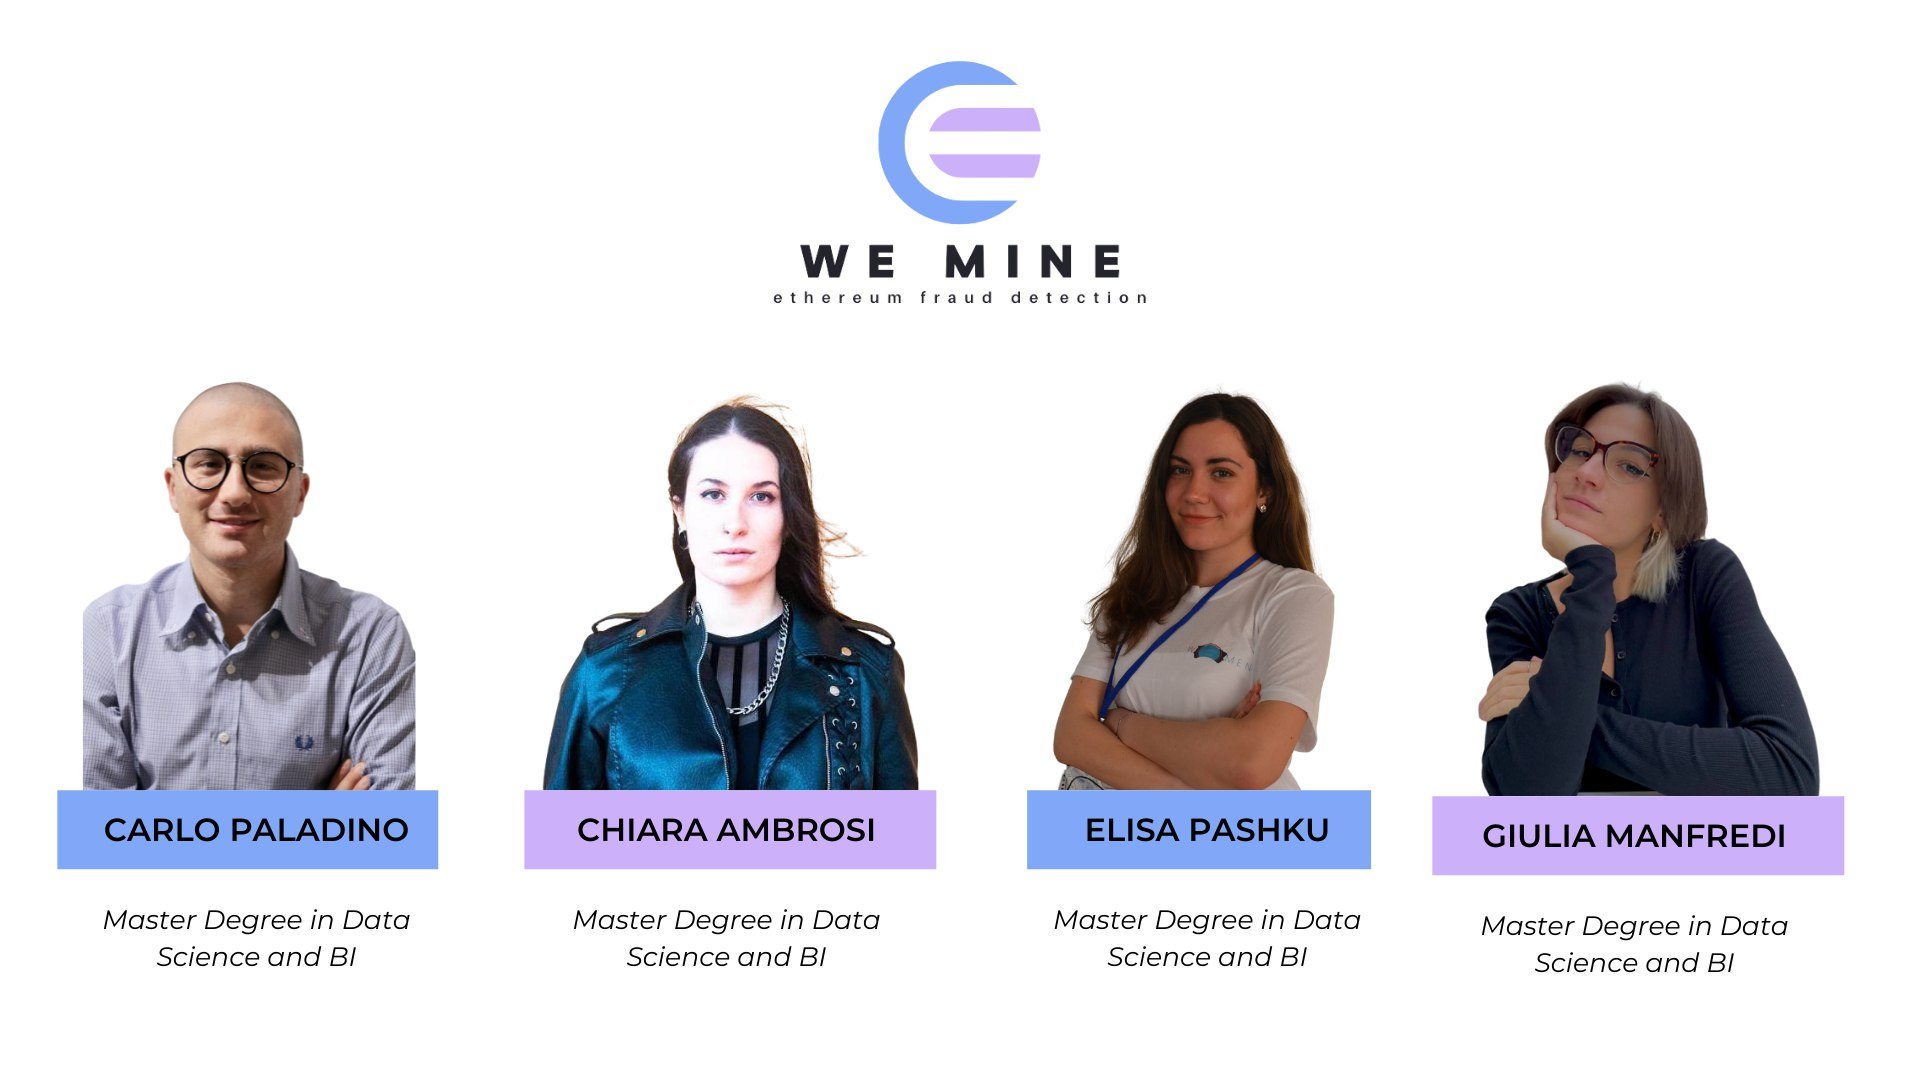

# From previous notebooks...

The aim of the project was to *identify fraudulent accounts in the Ethereum transactions dataset*. 

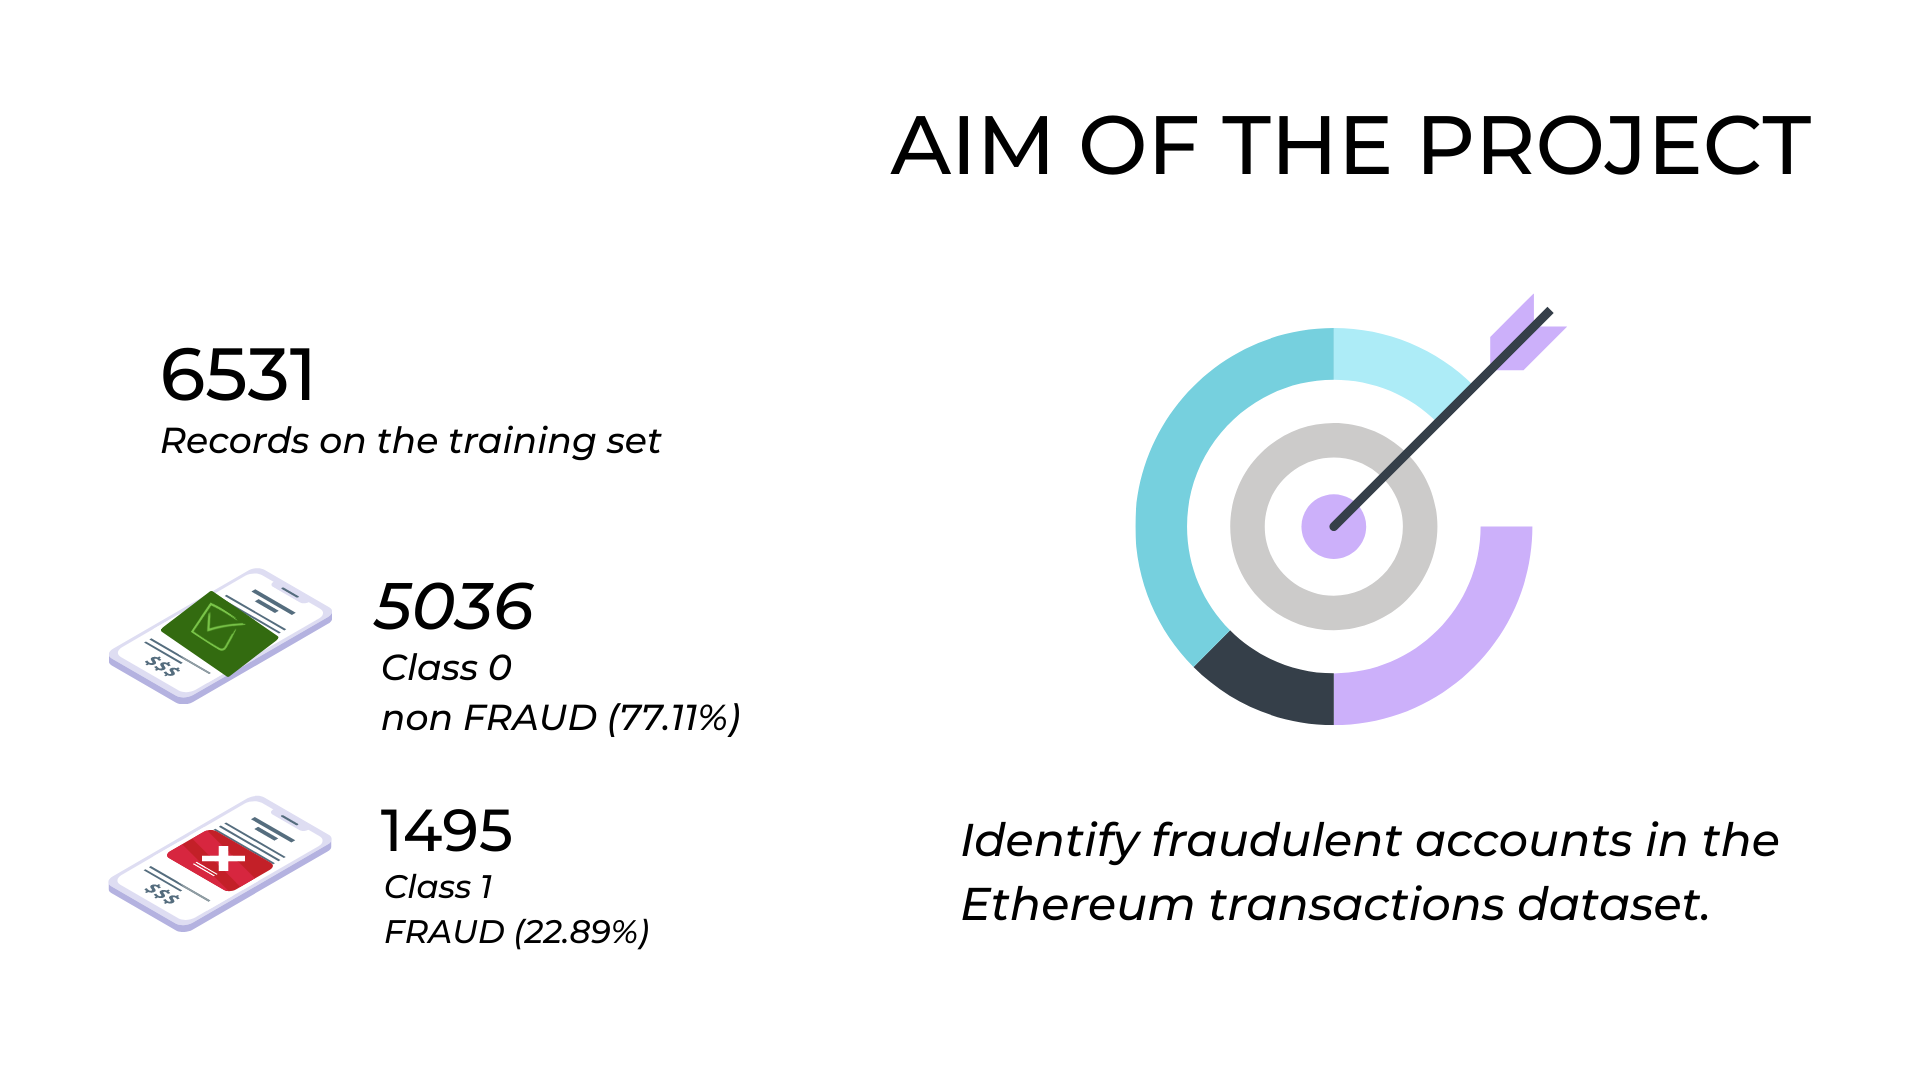

To achieve that some steps have been performed:

*   Data Understanding, Cleaning and Feature Selection, from which it has been extracted a 14 features dataset;
*   Modeling the problem with a binary classification, from which it has been discovered that the best method was Random Forest;
*   Unbalanced Learning (oversampling of the minority class and undersampling of the majority one), from which it has been observed that the performance didn't change that much from the original unbalanced dataset;
*   Pattern Mining, from which rules have been extracted in order to find the specific features that impact on the classification, to further investigate them with the explanation;
*   Global and Local Explanation with SHAP, from which it has been analyzed how attributes contribute to the classification.

From these steps (especially the last one), it has been discovered that among all the attributes, Total ERC20 tnxs and ERC20 most sent token type are the most important for the classification. Depending on their values they could lead to both classes (fraud or non fraud) and they are the most important factors for a good classification, regardless of the specific output.


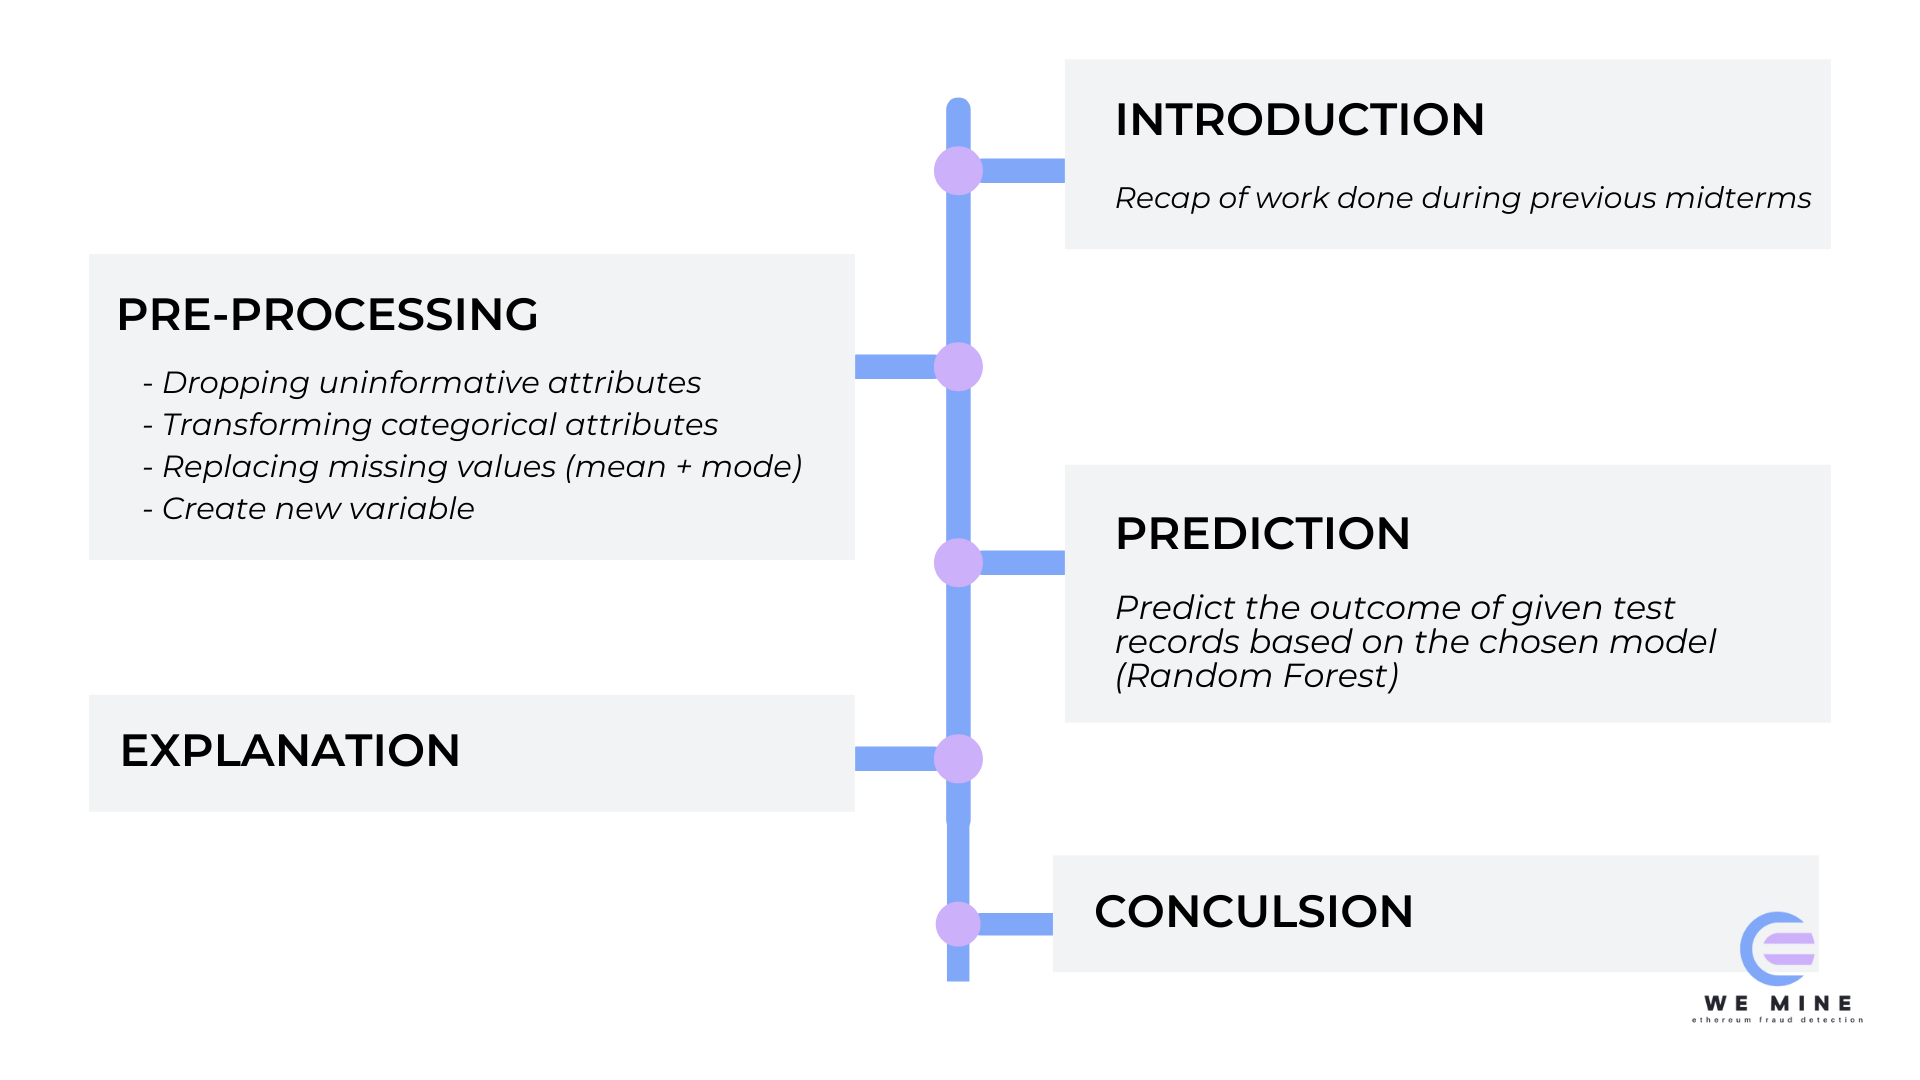

# Introduction and Goals

In this notebook a dataset with only 5 records will be used as a test set to check if the trained model can give a good prediction of the fraudulent accounts. 

For preprocessing, a function has been created in order to clean the dataset. Then the model already trained (with the 14 features dataset) has been imported and the prediction has been done on the test set composed of 5 records. The results of the test set classification have been compared to the train ones.

Finally, SHAP local explanation of the test set has been performed checking if the prediction correctly classified the fraudulent or non fraudulent accounts, with the help of waterfall plots.

In [3]:
# Importing the libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder

In [4]:
og = pd.read_csv("/content/drive/MyDrive/Jovian/ethereum-fraud-detection/transaction_dataset.csv", index_col=0)
print(og.shape)
og.head()

(9841, 50)


,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,total ether balance,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 avg time between sent tnx,ERC20 avg time between rec tnx,ERC20 avg time between rec 2 tnx,ERC20 avg time between contract tnx,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,45.806785,6.589513,0.00,31.220000,1.200681,0.0,0.0,0.0,810,865.691093,586.466675,0.0,-279.224419,265.0,3.558854e+07,3.560317e+07,0.0,30.0,54.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,1.500000e+07,265586.147600,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,2.613269,0.385685,0.00,1.800000,0.032844,0.0,0.0,0.0,102,3.087297,3.085478,0.0,-0.001819,8.0,4.034283e+02,2.260809e+00,0.0,1.0,5.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,3.650000e+02,57.632615,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,1.165453,0.358906,0.05,3.538616,1.794308,0.0,0.0,0.0,12,3.588616,3.589057,0.0,0.000441,8.0,5.215121e+02,0.000000e+00,0.0,0.0,7.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,4.428198e+02,65.189009,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,None,XENON
3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,500.000000,99.488840,0.00,450.000000,70.001834,0.0,0.0,0.0,34,1750.045862,895.399559,0.0,-854.646303,14.0,1.711105e+04,1.141223e+04,0.0,2.0,11.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,1.141223e+04,1555.550174,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,12.802411,2.671095,0.00,9.000000,0.022688,0.0,0.0,0.0,4619,104.318883,53.421896,0.0,-50.896986,42.0,1.628297e+05,1.235399e+05,0.0,4.0,23.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,9.000000e+04,4934.232147,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [ ]:
# for testing
# new = og.sample(n=5)
# new.to_csv("/content/drive/MyDrive/Jovian/ethereum-fraud-detection/test.txt", header=True, index=False, sep='\t', mode='w')

In [5]:
new = pd.read_csv('/content/drive/MyDrive/Jovian/ethereum-fraud-detection/test.txt', header=0, sep='\t', skiprows=0)
new

,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,total ether balance,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 avg time between sent tnx,ERC20 avg time between rec tnx,ERC20 avg time between rec 2 tnx,ERC20 avg time between contract tnx,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,1858,0x7f515b823fd5ffd3c3659ffb14e2c6df3bf60603,0,161.74,0.00,323.48,2,2,0,2,2,4.143530,96.856470,50.500000,8.000000,92.998974,50.499487,0.0,0.0,0.0,4,100.998974,101.000000,0.0,0.001026,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,1410,0xa3efa3aeb27711b51b8bd12d8bf0885d4949f065,1,0.00,713.45,3413.90,1,4,0,4,1,0.490000,10.000000,2.927811,11.709167,11.709167,11.709167,0.0,0.0,0.0,5,11.709167,11.711246,0.0,0.002079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3689,0xb0b0f6682da4c6079224755955c004343ac4bc30,0,3219.86,21753.52,150625.80,13,5,0,2,6,0.010195,0.842868,0.220441,0.000000,0.837618,0.083988,0.0,0.0,0.0,18,1.091840,1.102204,0.0,0.010364,5.0,98.023186,98.0,0.0,2.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,98.023185,32.674395,0.0,98.0,49.0,0.0,0.0,0.0,2.0,3.0,Crypto.com,Monaco
3,1807,0x7e17f286b44b782d4f1e8a4cfcbc7b7811a9e9a8,0,0.00,0.00,39.53,1,1,0,1,1,0.145844,0.145844,0.145844,0.145340,0.145340,0.145340,0.0,0.0,0.0,2,0.145340,0.145844,0.0,0.000504,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,4410,0xc57cc290cf651ae1b30503de087a9b755521c3c3,0,5.82,2913.52,388265.52,132,133,0,3,1,0.011211,1.743090,0.223223,0.098307,1.742435,0.224254,0.0,0.0,0.0,265,29.601560,29.688701,0.0,0.087142,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


# Preprocessing functions


Some unuseful columns have been deleted, like the Index, already present in the dataset, the Address, which was unique for each account, and the columns that brought no information, for example those with variance 0. 
The 'FLAG' column has been renamed into 'Fraud', so it's more understandable.
The missing values were replaced with the median for the numerical attributes and with the mode for the categorical ones. 
Then the Time Diff between first and last (Mins) has been transformed into days, to have a better understanding of the actual time.

In [6]:
def preprocess(df):
  df = df.drop(['Index', 'Address', ' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx',' ERC20 avg time between rec 2 tnx',
              ' ERC20 avg time between contract tnx',' ERC20 min val sent contract',' ERC20 max val sent contract',
              ' ERC20 avg val sent contract', 'avg val received', 'avg val sent', 'avg value sent to contract', ' ERC20 avg val rec',' ERC20 avg val sent',
           'min value sent to contract', 'max val sent to contract', 'total ether sent contracts'], axis=1)
  # Create a dictionary with columns as keys and its number of missing values
  d = dict(df.isnull().sum())
  # For every column if the number of missing values is greater than 0 i append the name of the column in the list l
  l=[]
  for i in d.keys():
    if d[i] > 0:
      l.append(i)
  for col in l[:-2]:
    df[col] = df[col].fillna(og[col].median())
  for col in l[-2:]:
    df[col] = df[col].fillna(og[col].mode()[0])
  df = df.rename(columns={"FLAG": "Fraud"})
  # Creating a new variable 
  days_diff = []
  for value in df['Time Diff between first and last (Mins)']:
    days_diff.append(int(value / (60*24)))
  df['Time Diff between first and last tnx (Days)'] = days_diff
  # Dropping one attribute for each pair for highly correlated variables (threshold > 0.8)
  df = df.drop(df.columns.difference(['Avg min between received tnx', 'Sent tnx',
       'Unique Received From Addresses', 'max value received ',
       'total ether received', ' Total ERC20 tnxs', ' ERC20 uniq sent addr',
       ' ERC20 max val rec', ' ERC20 min val sent', ' ERC20 max val sent',
       ' ERC20 most sent token type', ' ERC20_most_rec_token_type',
       'Time Diff between first and last tnx (Days)', 'Fraud']), axis=1)
  return df

In [7]:
new = preprocess(new)

In [8]:
# creating a variable in which the original values of ERC20 most sent token types are stored so that later check them for explanation
sent = new[' ERC20 most sent token type']
sent

0             0
1             0
2    Crypto.com
3             0
4             0
Name:  ERC20 most sent token type, dtype: object

The categorical variables are transformed using the LabelEncoder().

In [9]:
def encoder(df):
  # Encode labels with value between 0 and n_classes-1
  # Convert all values to numbers so it's easier for the data mining algorithms
  le_sent_token_type = LabelEncoder()
  le_rec_token_type = LabelEncoder()
  # The method fit_transform is used
  df[' ERC20 most sent token type'] = le_sent_token_type.fit_transform(df[' ERC20 most sent token type'])
  df[' ERC20_most_rec_token_type'] = le_rec_token_type.fit_transform(df[' ERC20_most_rec_token_type'])
  return df

In [10]:
new = encoder(new)

In [11]:
print(new.shape)
new.head()

(5, 14)


,Fraud,Avg min between received tnx,Sent tnx,Unique Received From Addresses,max value received,total ether received,Total ERC20 tnxs,ERC20 uniq sent addr,ERC20 max val rec,ERC20 min val sent,ERC20 max val sent,ERC20 most sent token type,ERC20_most_rec_token_type,Time Diff between first and last tnx (Days)
0,0,0.00,2,2,96.856470,101.000000,0.0,0.0,0.000000,0.0,0.0,0,0,0
1,1,713.45,1,4,10.000000,11.711246,1.0,0.0,0.000000,0.0,0.0,0,0,2
2,0,21753.52,13,2,0.842868,1.102204,5.0,2.0,98.023185,0.0,98.0,1,1,104
3,0,0.00,1,1,0.145844,0.145844,0.0,0.0,0.000000,0.0,0.0,0,0,0
4,0,2913.52,132,3,1.743090,29.688701,0.0,0.0,0.000000,0.0,0.0,0,0,269


# Model implementation and predictions

The dataset used for the training of the model has been imported to see how the results change for the test dataset with respect to the train one.

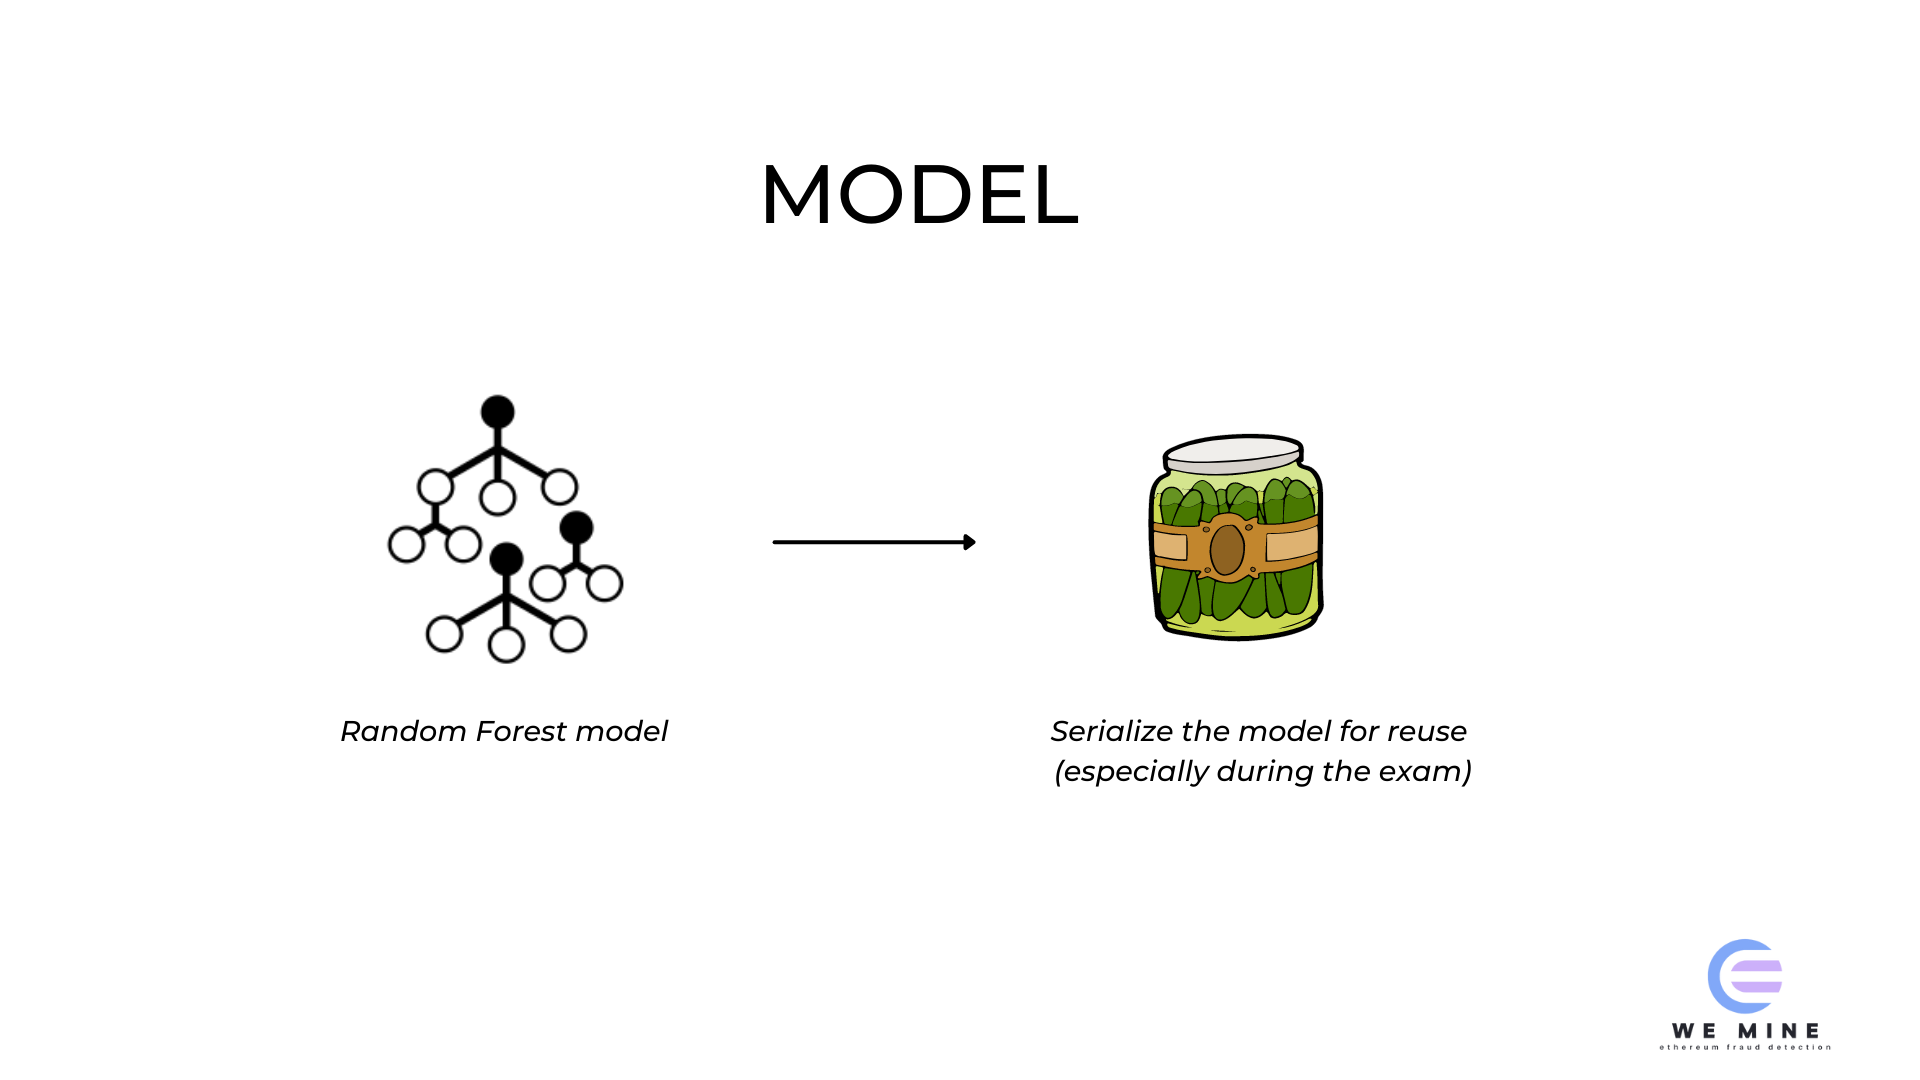

In [12]:
cl = pd.read_csv("/content/drive/MyDrive/Jovian/ethereum-fraud-detection/14_df.csv", index_col=0)

In [13]:
Y_test = new['Fraud']
X_test = new.drop(['Fraud'], axis=1)

In [14]:
Y_train = cl['Fraud']
X_train = cl.drop(['Fraud'], axis=1)

**Importing the selected model and testing it on the selected records**



In [15]:
# load the model from disk
import pickle
from sklearn.metrics import *
filename = '/content/drive/MyDrive/Jovian/finalized_model.sav'
model = pickle.load(open(filename, 'rb'))
y_pred = model.predict(X_test)
y_pred_tr = model.predict(X_train)
print('Train Accuracy %s' % accuracy_score(Y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(Y_train, y_pred_tr, average='weighted'))
print('Train Precision %s' % precision_score(Y_train, y_pred_tr, average='weighted'))
print('Train Recall %s' % recall_score(Y_train, y_pred_tr, average='weighted'))
print()
print('Test Accuracy %s' % accuracy_score(Y_test, y_pred))
print('Test F1-score %s' % f1_score(Y_test, y_pred, average='weighted'))
print('Test Precision %s' % precision_score(Y_test, y_pred, average='weighted'))
print('Test Recall %s' % recall_score(Y_test, y_pred, average='weighted'))

Train Accuracy 0.9913590783016855
Train F1-score 0.9913145375377889
Train Precision 0.9913971631260029
Train Recall 0.9913590783016855

Test Accuracy 0.4
Test F1-score 0.4
Test Precision 0.85
Test Recall 0.4


It has been observed that precision tends to be higher than other measures and, since precision is the ratio between true positive and the sum of true positive and false positive, it means that the proportion of positive identifications that was actually correct is high. So, in this case, it is expected that frauds are usually correctly classified.

In the cell below the real and predicted values for the target variable have been checked.

In [16]:
print(Y_test, "\n", y_pred)

0    0
1    1
2    0
3    0
4    0
Name: Fraud, dtype: int64 
 [0 1 1 1 1]


# Explanation (SHAP)

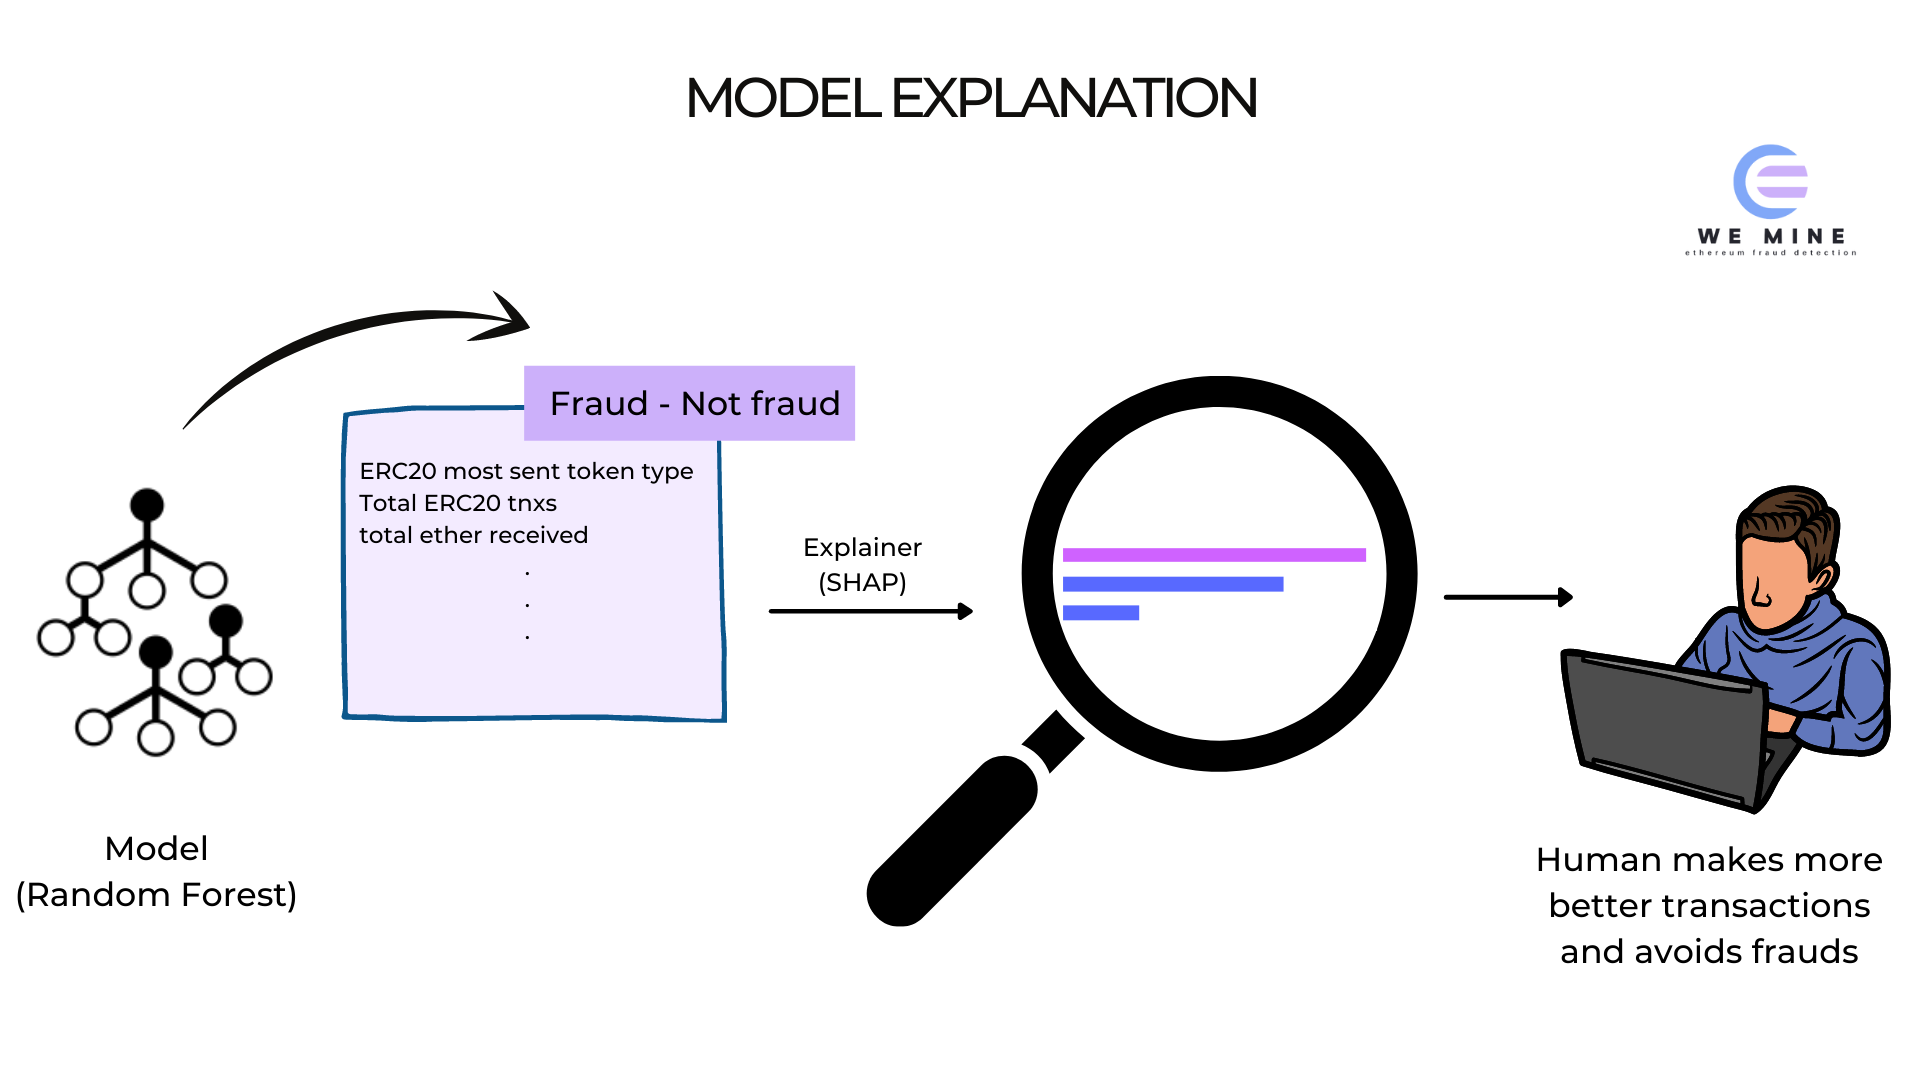

From this graph obtained from the previous global explanation, the two attributes that seem to be the most important ones in the classification are Total ERC20 tnxs and ERC20 most sent token type. As seen on the third midterm, ERC20 most sent token type is the one that may help the classification a lot, recognizing a fraud when it wouldn't be otherwise seen as such, or report a record as a false positive.

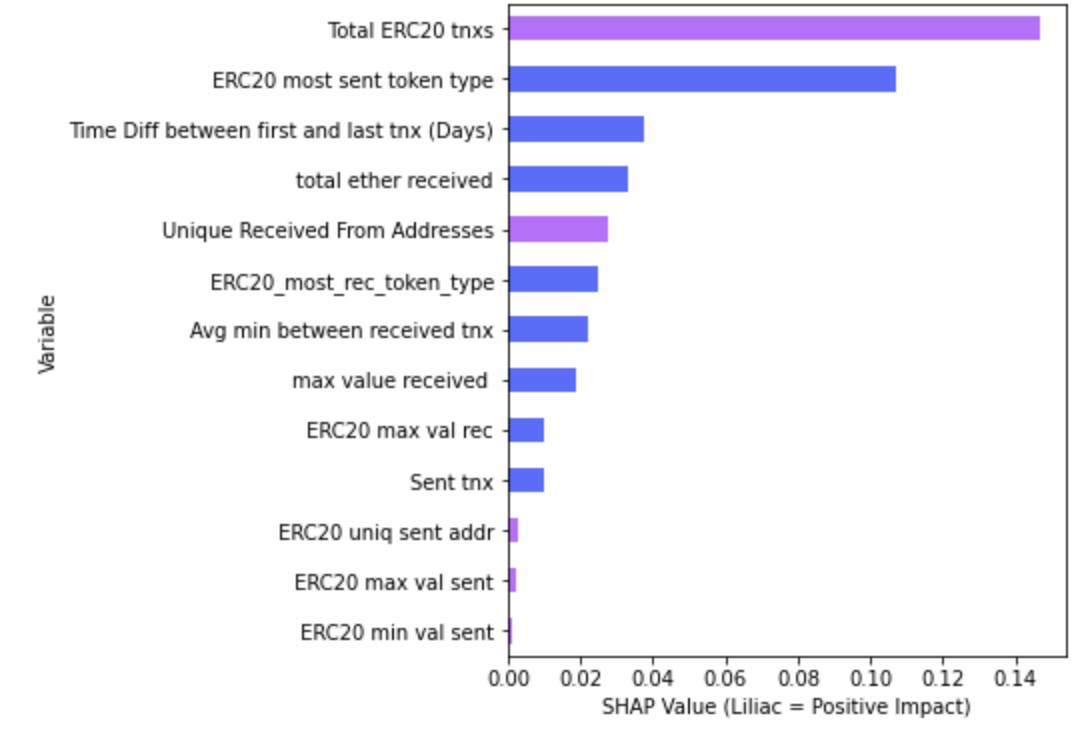

In [17]:
!pip install shap

     |████████████████████████████████| 564 kB 5.3 MB/s 


In [18]:
import shap

In [19]:
# Created to make waterfall_plot work, that otherwise wouldn't find some of these values
class ShapObject: 
  def __init__(self, base_values, data, values, feature_names):
      self.base_values = base_values # Single value
      self.data = data # Raw feature values for 1 row of datas
      self.values = values # SHAP values for the same row of data
      self.feature_names = feature_names # Column names

In [20]:
explainer = shap.TreeExplainer(model)

In [21]:
values = explainer.shap_values(X_test)[1]

The explanation for each reacord will be printed in the cell below, along with the information about the most sent token type (since in the global explanations and in the third midterm it was interesting to observe which the real sent token type was) and whether or not the record has been correctly or wrongly classified.

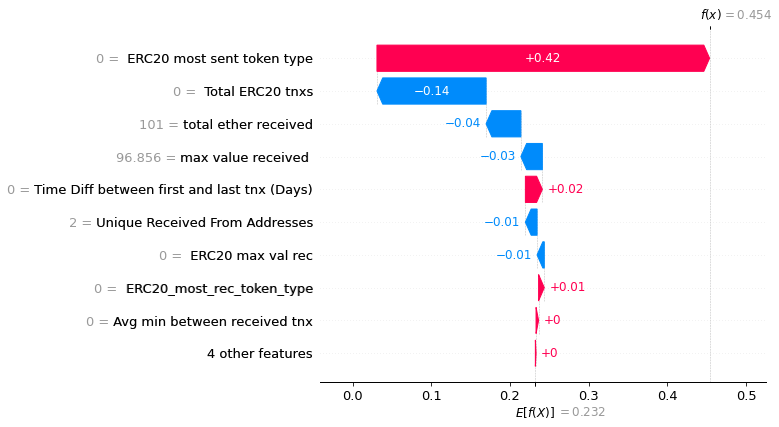

Correctly classfied: 
 actual class 0 VS predicted class 0
ERC20 most sent token type:  0


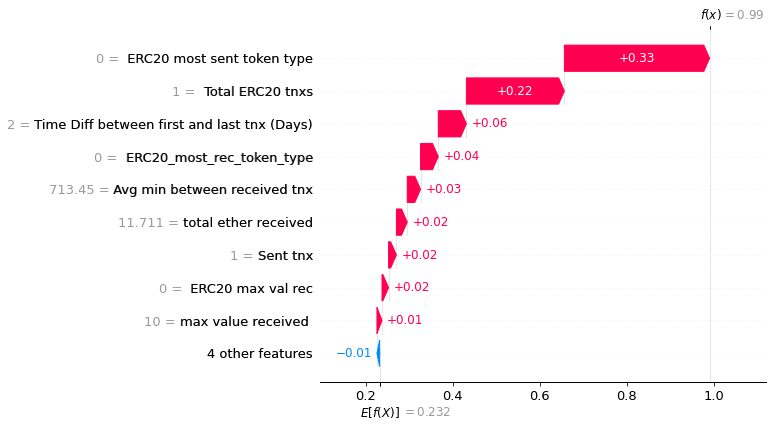

Correctly classfied: 
 actual class 1 VS predicted class 1
ERC20 most sent token type:  0


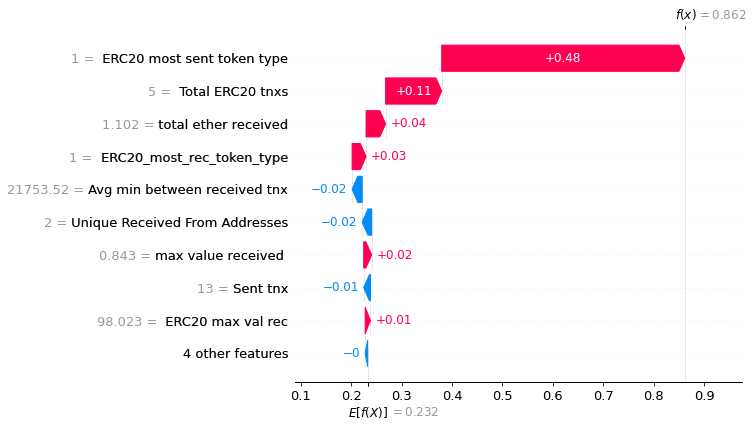

Wrongly classified: 
 actual class 0 VS predicted class 1
ERC20 most sent token type:  Crypto.com


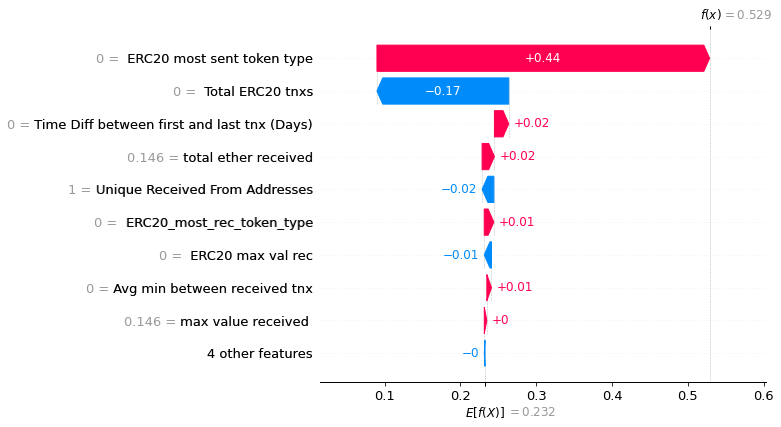

Wrongly classified: 
 actual class 0 VS predicted class 1
ERC20 most sent token type:  0


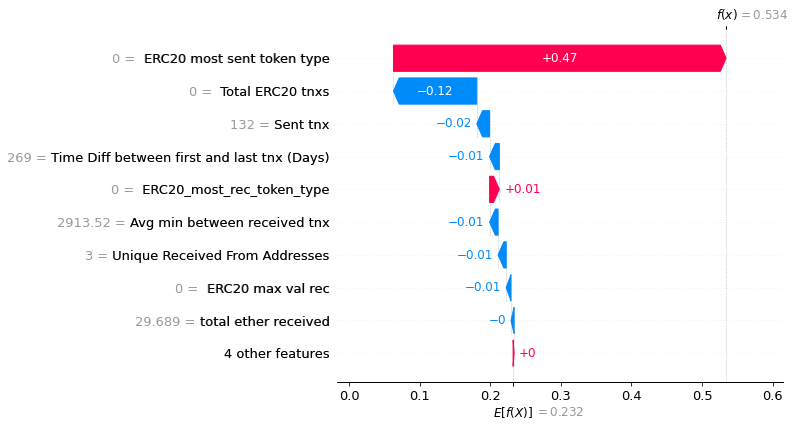

Wrongly classified: 
 actual class 0 VS predicted class 1
ERC20 most sent token type:  0


In [22]:
for index in range(len(values)):
  shap_object = ShapObject(base_values = explainer.expected_value[1],
                         values = values[index],
                         feature_names = X_test.columns,
                         data = X_test.iloc[index])
  shap.waterfall_plot(shap_object)
  if Y_test.iloc[index] == y_pred[index]:
    print("Correctly classfied: \n actual class {} VS predicted class {}".format(Y_test.iloc[index], y_pred[index]))
  else:
    print("Wrongly classified: \n actual class {} VS predicted class {}".format(Y_test.iloc[index], y_pred[index]))
  print("ERC20 most sent token type: ", sent[index])


In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="final-term")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/c-ambrosi/final-term1


'https://jovian.ai/c-ambrosi/final-term1'